# Gallstone Disease Prediction with Explainable Artificial Intelligence

## Group Members 

- Augustus Clark Raphael P. Rodriguez
- James Angelo R. Dela Cruz
- Harry William R. Acosta II 
- Jasper Anthony G. Perillo

## Description 
This notebook entails the development and assessment of a selection of machine learning models to determine which performs the best under given testing conditions.


#### Project Setup

In [88]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn imblearn shap
!{sys.executable} -m pip install lime

In [89]:
# Import core libraries
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import GaussianNB # Removed due to low performance
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# Hyper Parameter Tuning
from sklearn.model_selection import GridSearchCV

# XAI
import shap
from lime.lime_tabular import LimeTabularExplainer

### Load Dataset
Dataset has been converted from .xlsx to .csv for processing convenience.

In [90]:
# Load dataset
df = pd.read_csv('(CSV)dataset-uci.csv')

# Inspect dataset shape and columns
print(f'Dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')

target_col = 'Gallstone Status'  # Target variable

Dataset shape: (319, 39)
Columns: ['Gallstone Status', 'Age', 'Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Height', 'Weight', 'Body Mass Index (BMI)', 'Total Body Water (TBW)', 'Extracellular Water (ECW)', 'Intracellular Water (ICW)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Body Protein Content (Protein) (%)', 'Visceral Fat Rating (VFR)', 'Bone Mass (BM)', 'Muscle Mass (MM)', 'Obesity (%)', 'Total Fat Content (TFC)', 'Visceral Fat Area (VFA)', 'Visceral Muscle Area (VMA) (Kg)', 'Hepatic Fat Accumulation (HFA)', 'Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']


### Model Evaluation Method 
Defined model evaluation function to evaluate model performance, will be used later on.

In [91]:
def evaluate_model(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    
    # Model Metrics
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc is not None:
        print(f"ROC AUC: {auc:.4f}")

### Cross-Validation Model Evaluation Method

In [132]:
def cross_val_evaluate(model, X, y, cv):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring)

    metric_names = {
        'accuracy': 'Accuracy',
        'precision': 'Precision',
        'recall': 'Recall',
        'f1': 'F1 Score',
        'roc_auc': 'ROC AUC'
    }

    for metric in scoring:
        mean = np.mean(cv_results[f'test_{metric}'])
        std = np.std(cv_results[f'test_{metric}'])
        print(f"{metric_names[metric]}: {mean:.4f} (+/- {std:.4f})")

## Exploratory Data Analysis
The EDA for this notebook contains the following: 
- Checking  for Missing Values 
- Descriptive Statistics 
- Numerical Feature Distribution 
- Boxplots
- Correlation Heatmap 
- Class Distribution Analysis

### Verification of Missing values
Simple check of missing values for assurance even if dataset is said to be complete. 

In [93]:
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

Missing values per column:
 Gallstone Status                                  0
Age                                               0
Gender                                            0
Comorbidity                                       0
Coronary Artery Disease (CAD)                     0
Hypothyroidism                                    0
Hyperlipidemia                                    0
Diabetes Mellitus (DM)                            0
Height                                            0
Weight                                            0
Body Mass Index (BMI)                             0
Total Body Water (TBW)                            0
Extracellular Water (ECW)                         0
Intracellular Water (ICW)                         0
Extracellular Fluid/Total Body Water (ECF/TBW)    0
Total Body Fat Ratio (TBFR) (%)                   0
Lean Mass (LM) (%)                                0
Body Protein Content (Protein) (%)                0
Visceral Fat Rating (VFR)           

### Descriptive Statistics 

In [94]:
num_features = df.select_dtypes(include=np.number).columns.tolist()
num_features = [f for f in num_features if f != target_col]

print("\nDescriptive statistics for numerical features:")
# display.display(df[num_features].describe())
display(df[num_features].describe())


Descriptive statistics for numerical features:


Age      Gender  Comorbidity  Coronary Artery Disease (CAD)  \
count  319.000000  319.000000   319.000000                     319.000000   
mean    48.068966    0.492163     0.335423                       0.037618   
std     12.114558    0.500724     0.517340                       0.190568   
min     20.000000    0.000000     0.000000                       0.000000   
25%     38.500000    0.000000     0.000000                       0.000000   
50%     49.000000    0.000000     0.000000                       0.000000   
75%     56.000000    1.000000     1.000000                       0.000000   
max     96.000000    1.000000     3.000000                       1.000000   

       Hypothyroidism  Hyperlipidemia  Diabetes Mellitus (DM)     Height  \
count      319.000000      319.000000              319.000000  319.00000   
mean         0.028213        0.025078                0.134796  167.15674   
std          0.165841        0.156609                0.342042   10.05303   
min          0.000000        0.000000                0.000000  145.00000   
25%          0.000000        0.000000                0.000000  159.50000   
50%          0.000000        0.000000                0.000000  168.00000   
75%          0.000000        0.000000                0.000000  175.00000   
max          1.000000        1.000000                1.000000  191.00000   

           Weight  Body Mass Index (BMI)  ...  High Density Lipoprotein (HDL)  \
count  319.000000             319.000000  ...                      319.000000   
mean    80.564890              28.877116  ...                       49.475549   
std     15.709069               5.313707  ...                       17.718701   
min     42.900000              17.400000  ...                       25.000000   
25%     69.600000              25.250000  ...                       40.000000   
50%     78.800000              28.300000  ...                       46.500000   
75%     91.250000              31.850000  ...                       56.000000   
max    143.500000              49.700000  ...                      273.000000   

       Triglyceride  Aspartat Aminotransferaz (AST)  \
count    319.000000                      319.000000   
mean     144.502163                       21.684953   
std       97.904493                       16.697605   
min        1.390000                        8.000000   
25%       83.000000                       15.000000   
50%      119.000000                       18.000000   
75%      172.000000                       23.000000   
max      838.000000                      195.000000   

       Alanin Aminotransferaz (ALT)  Alkaline Phosphatase (ALP)  Creatinine  \
count                    319.000000                  319.000000  319.000000   
mean                      26.855799                   73.112539    0.800611   
std                       27.884413                   24.181069    0.176433   
min                        3.000000                    7.000000    0.460000   
25%                       14.250000                   58.000000    0.650000   
50%                       19.000000                   71.000000    0.790000   
75%                       30.000000                   86.000000    0.920000   
max                      372.000000                  197.000000    1.460000   

       Glomerular Filtration Rate (GFR)  C-Reactive Protein (CRP)  \
count                        319.000000                319.000000   
mean                         100.818903                  1.853856   
std                           16.971396                  4.989591   
min                           10.600000                  0.000000   
25%                           94.170000                  0.000000   
50%                          104.000000                  0.215000   
75%                          110.745000                  1.615000   
max                          132.000000                 43.400000   

       Hemoglobin (HGB)   Vitamin D  
count        319.000000  319.000000  

### Numerical Feature Distribution 

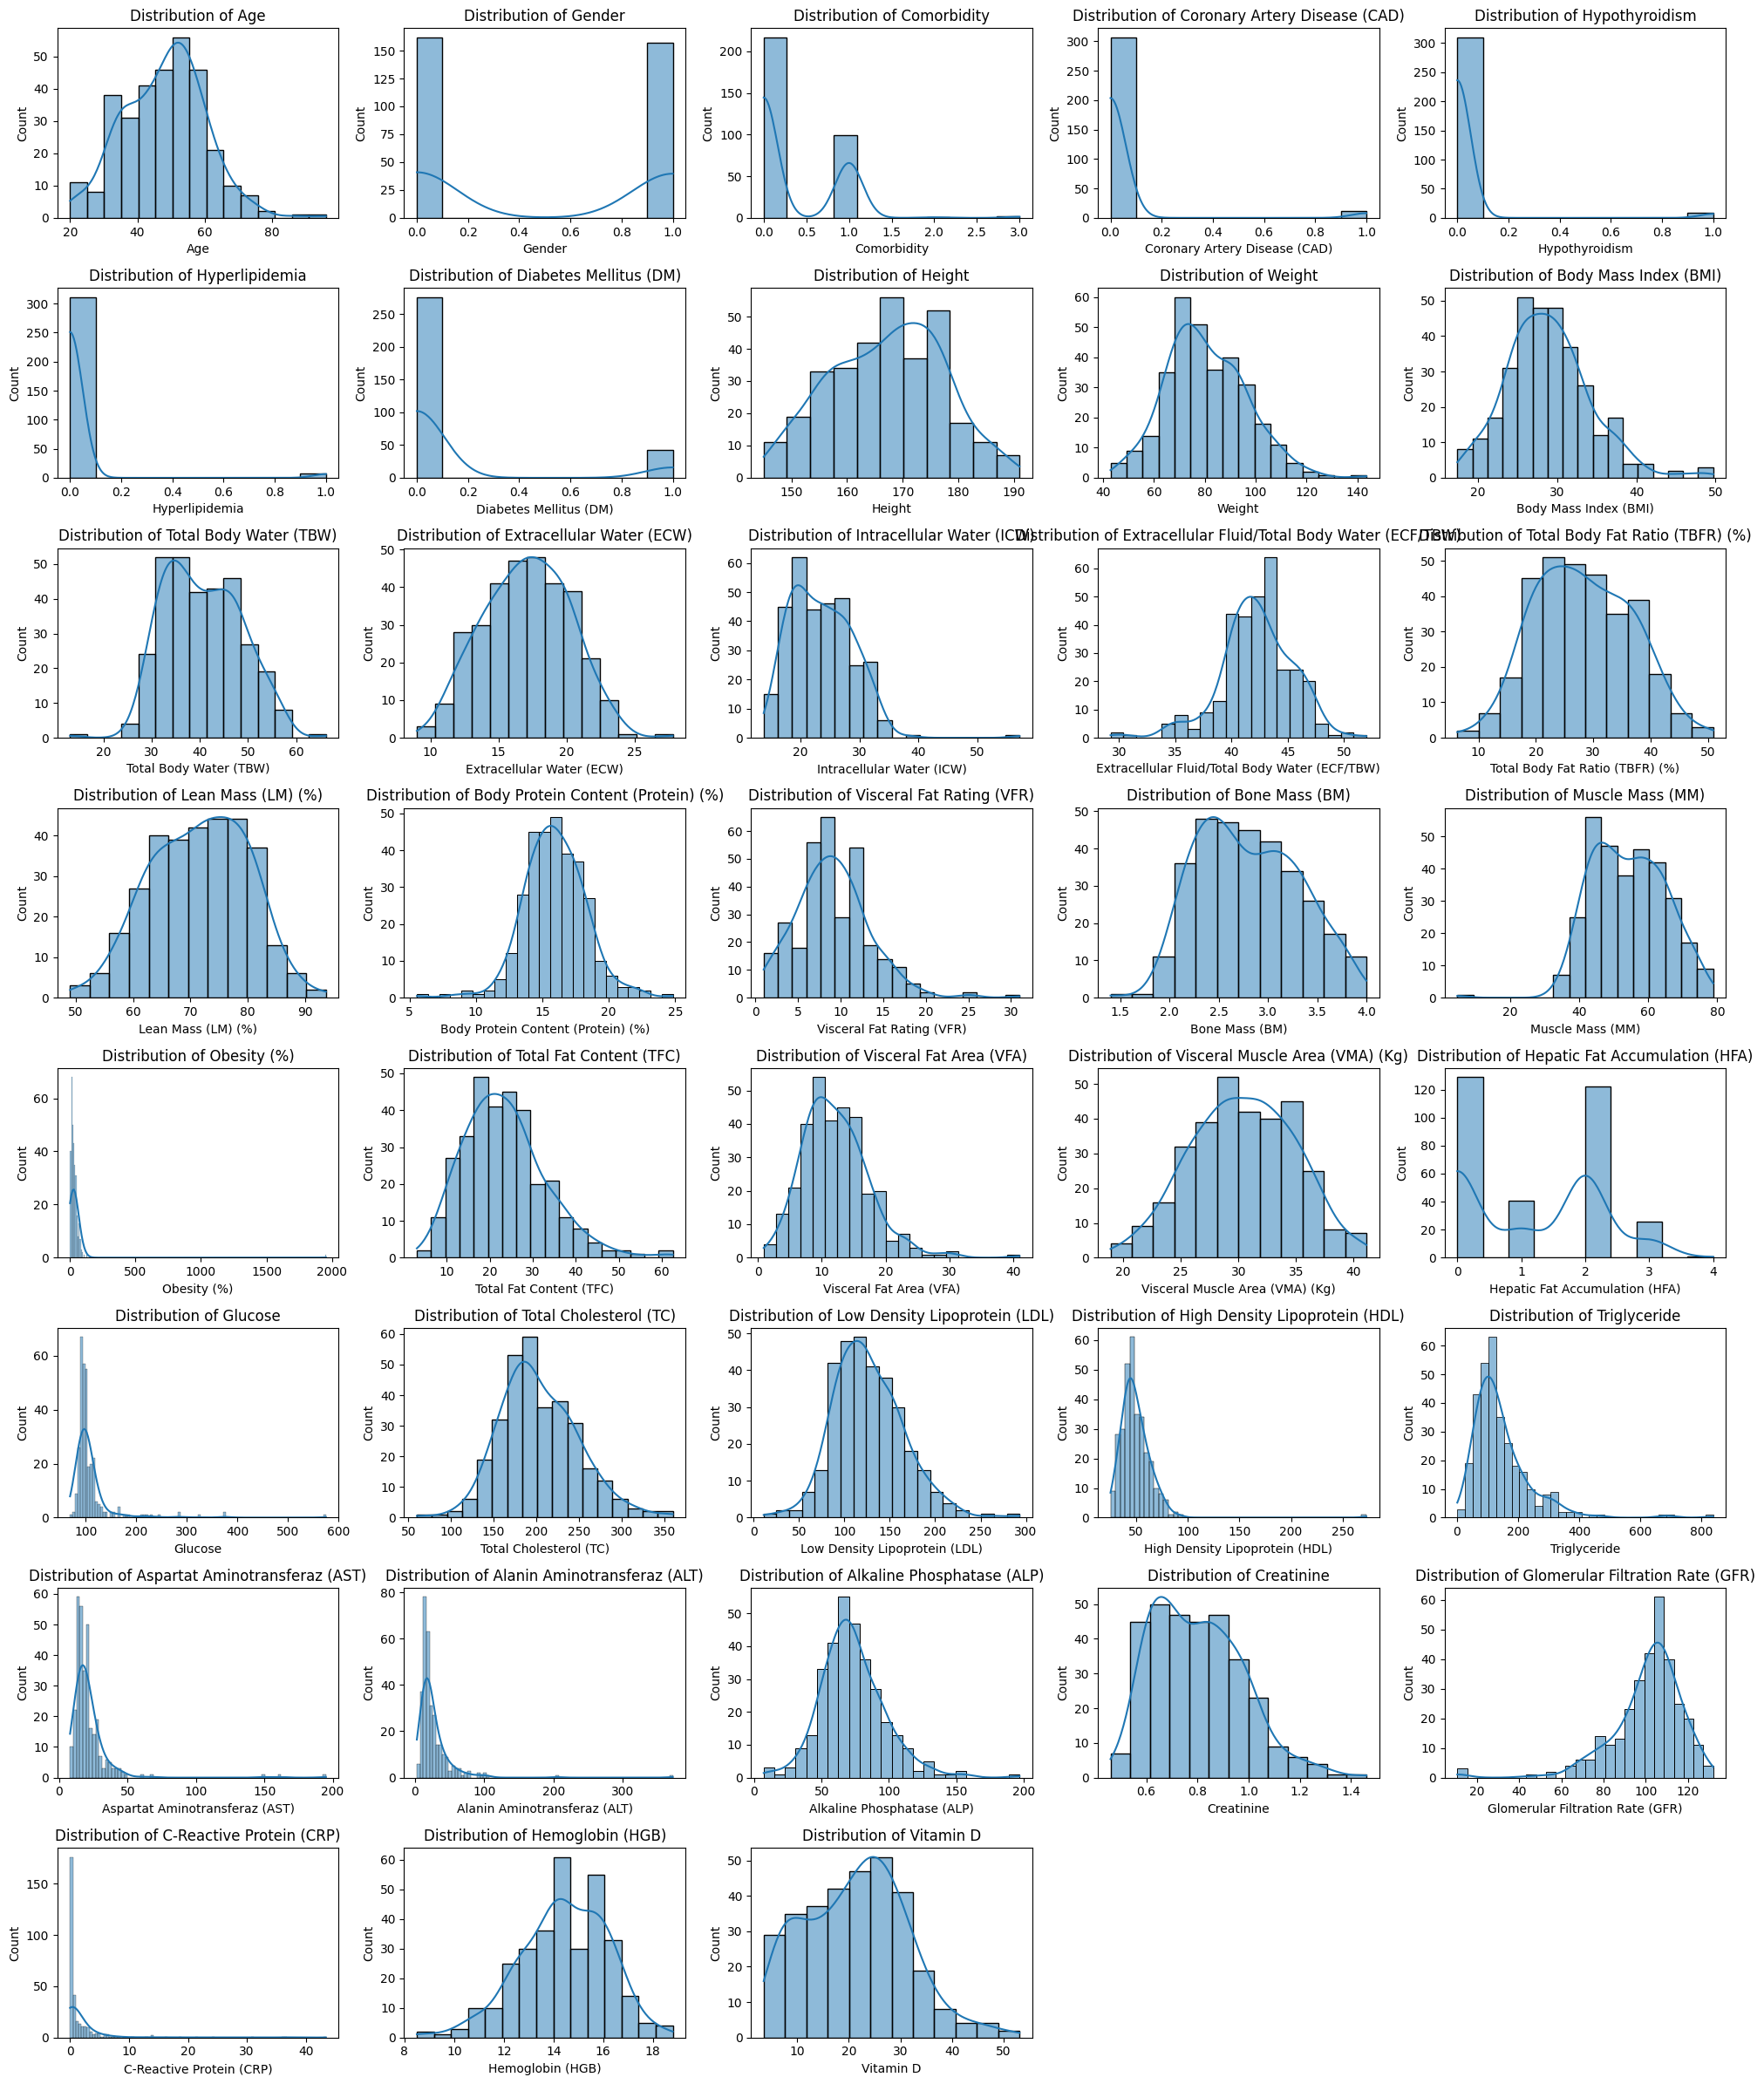

In [95]:
num_plots = len(num_features)
cols = 5  # or any number you prefer
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 4, rows * 3))  # Adjust figsize accordingly

for i, col in enumerate(num_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')

#plt.style.use('default')
plt.tight_layout()
plt.show()

### Boxplots to check for outliers in numerical features

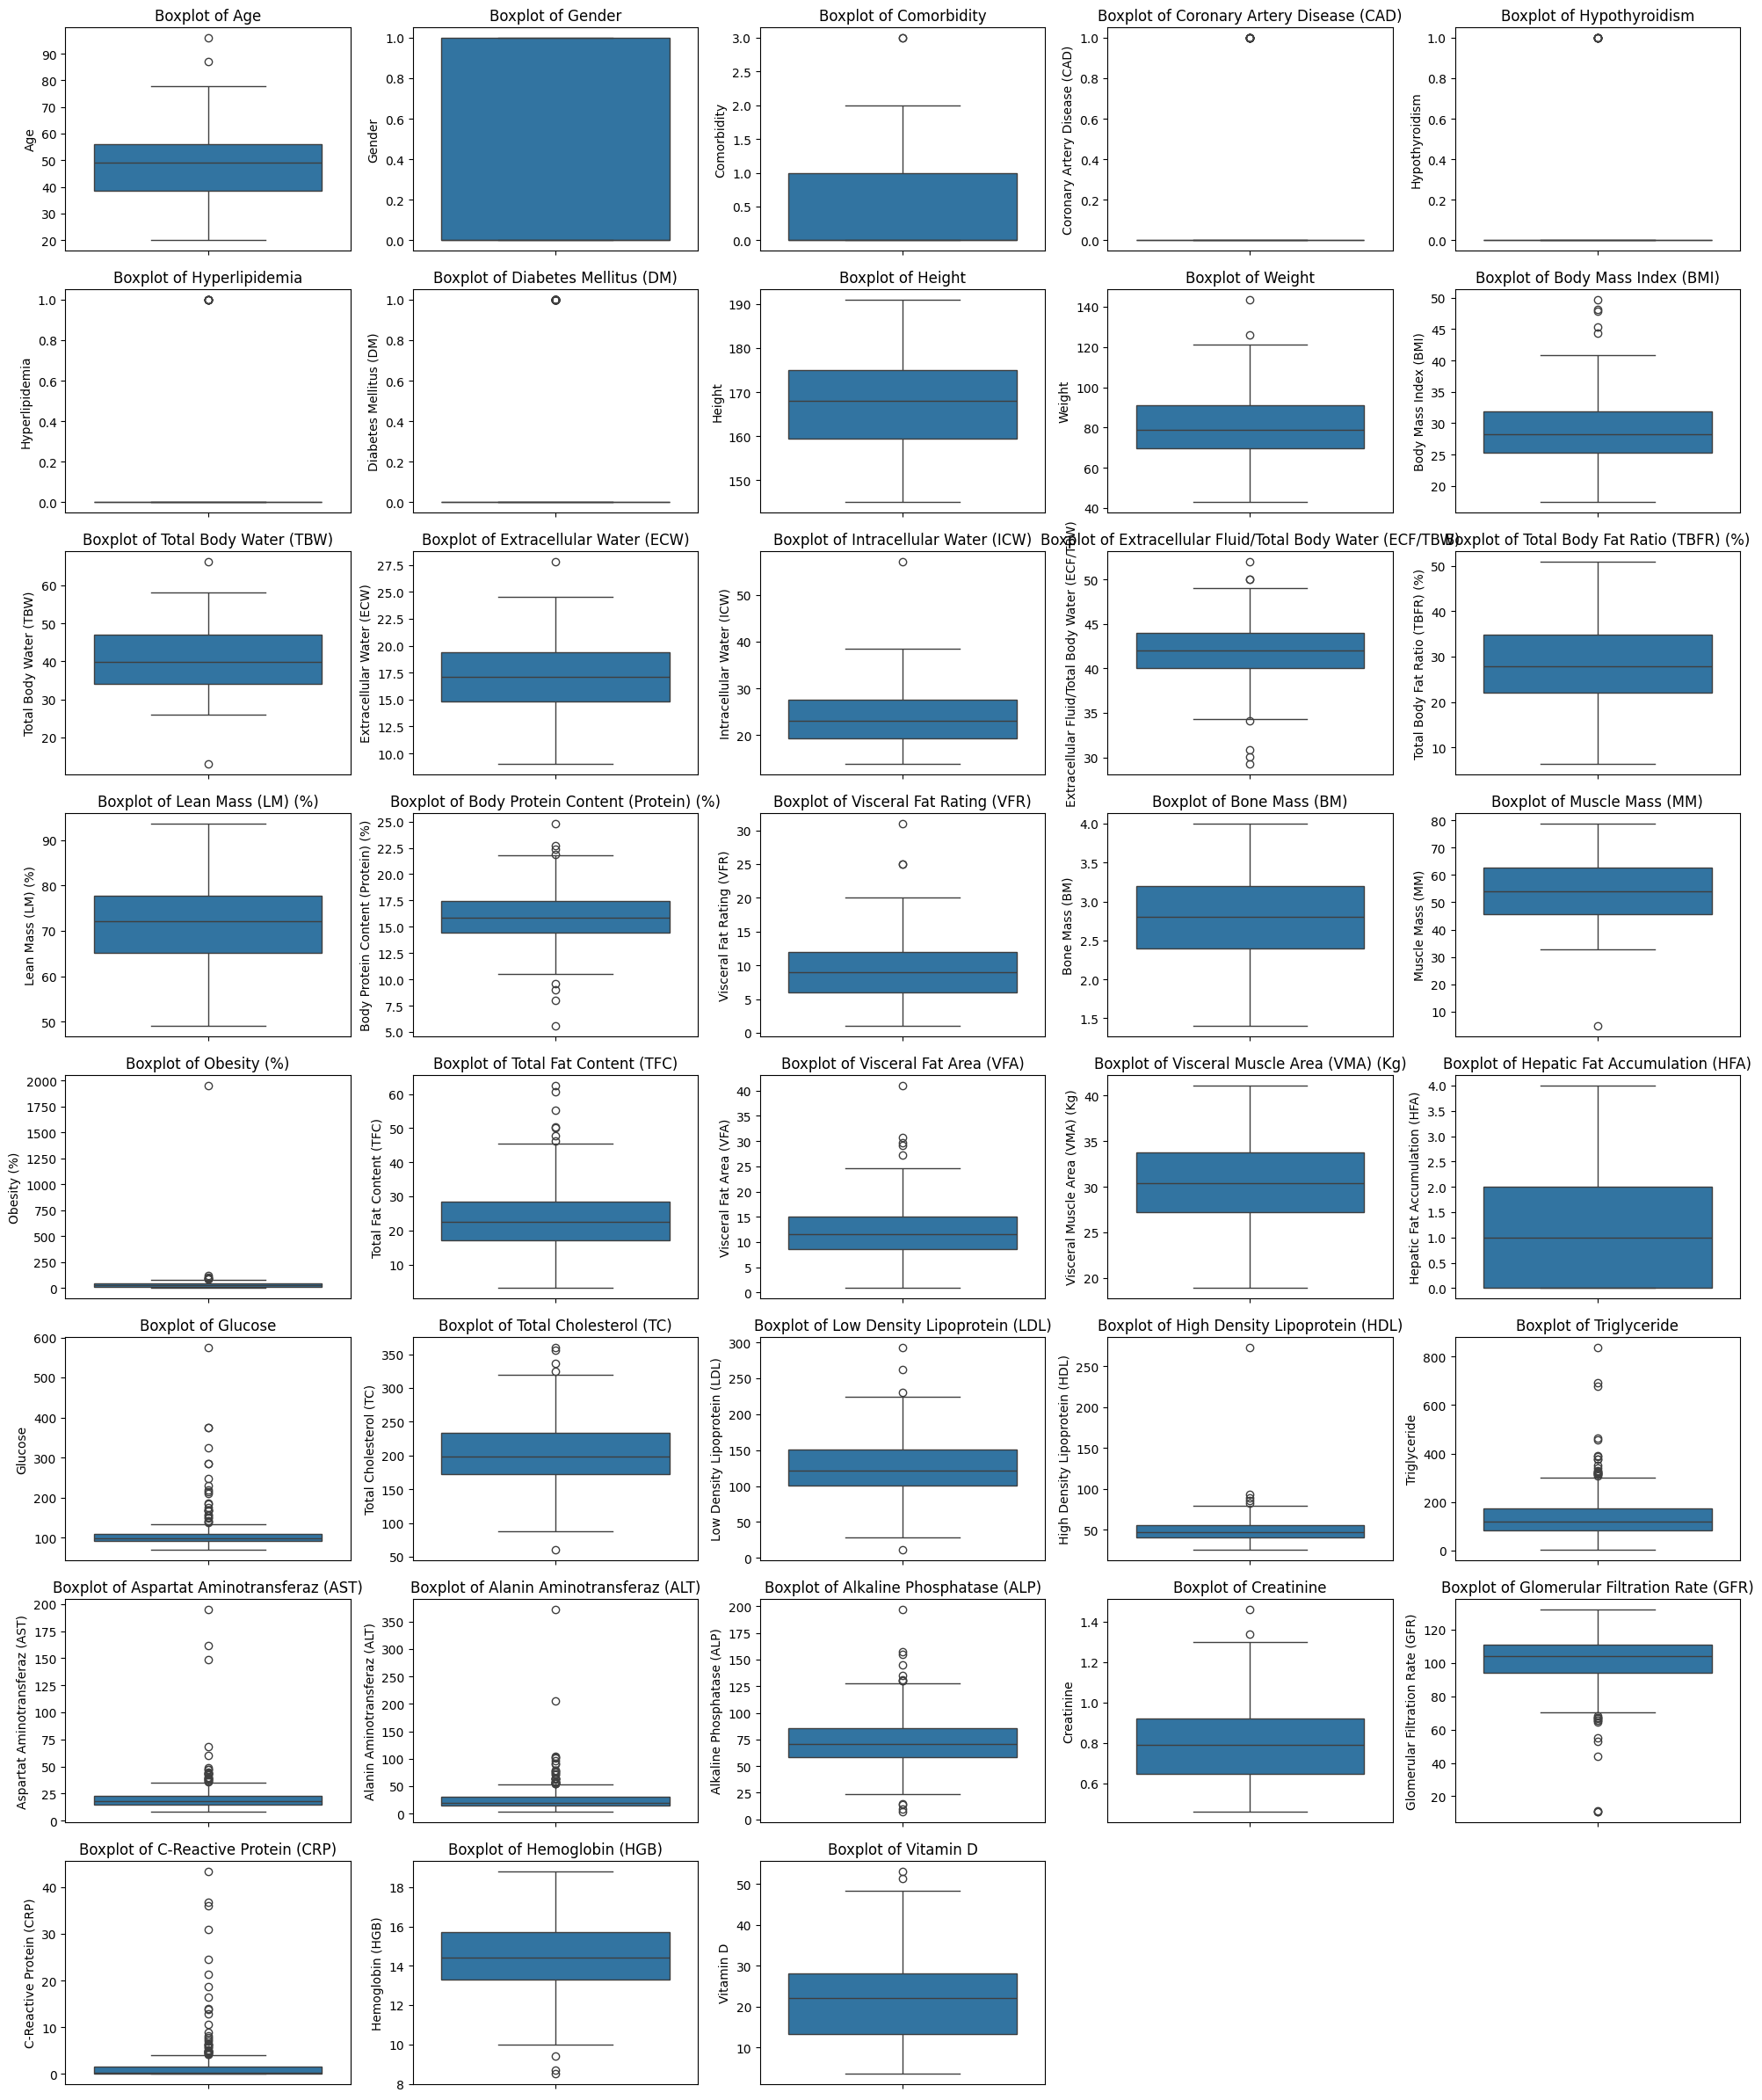

In [96]:
num_plots = len(num_features)
cols = 5  # number of columns you want
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 4, rows * 3))

for i, col in enumerate(num_features, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### Class Distribution Analysis 
In this block, the class distribution of the target variable is analyzed to check for class imbalance. Distribution will be analyzed overall and per gender. This will determine if SMOTE will be applied to the training data.


Overall class distribution:
Gallstone Status
0    161
1    158
Name: count, dtype: int64

Overall class distribution (percentage):
Gallstone Status
0    50.470219
1    49.529781
Name: proportion, dtype: float64


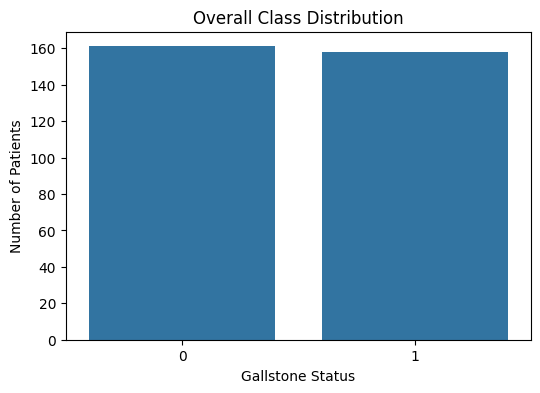

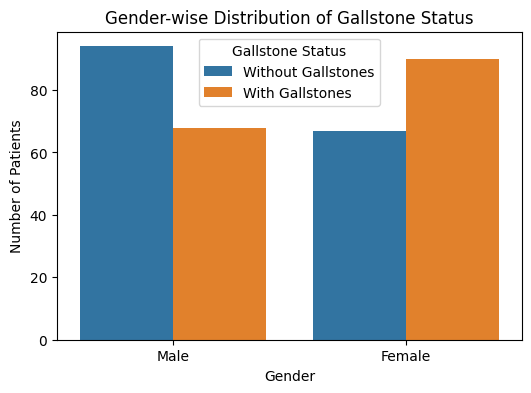

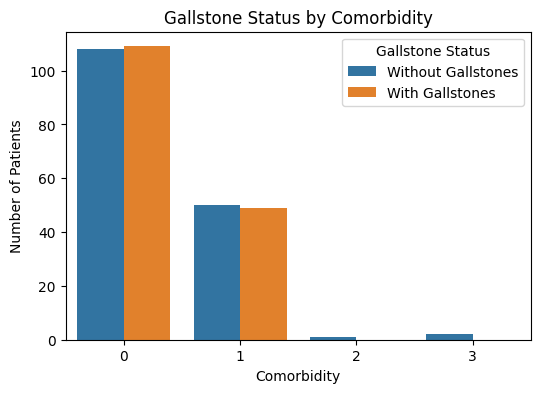

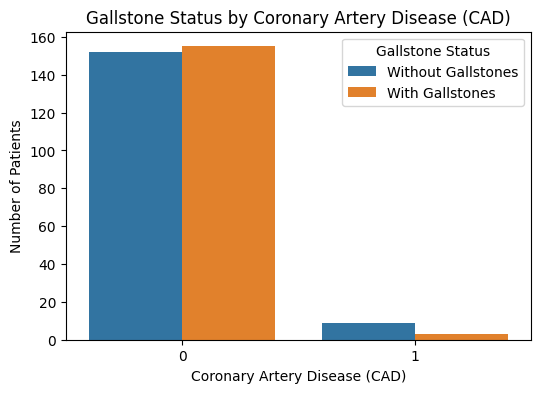

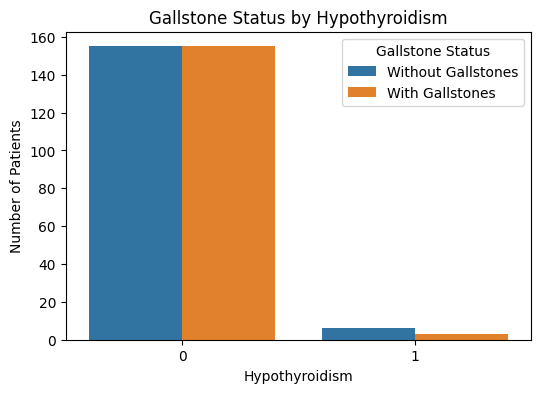

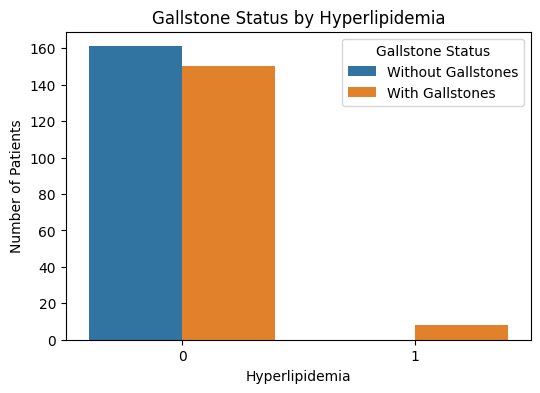

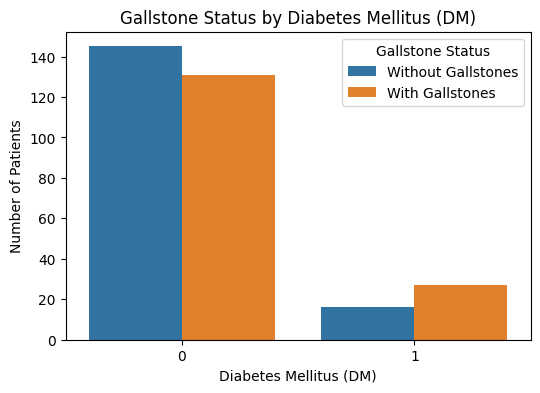

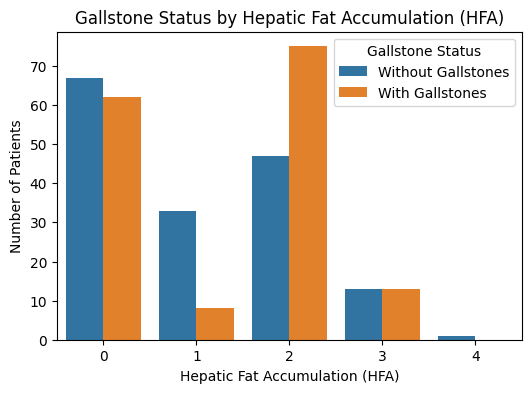

In [97]:
print("\nOverall class distribution:")
print(df[target_col].value_counts())
print("\nOverall class distribution (percentage):")
print(df[target_col].value_counts(normalize=True) * 100)

plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title('Overall Class Distribution')
plt.xlabel('Gallstone Status')
plt.ylabel('Number of Patients')
plt.show()

# -------------------------------
# Step 6b: Gender-wise class distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='Gender', hue=target_col)

# Set x-axis tick labels based on your encoding
ax.set_xticks([0, 1])
gender_labels = ['Male', 'Female']
ax.set_xticklabels(gender_labels)

plt.title('Gender-wise Distribution of Gallstone Status')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.legend(title='Gallstone Status', labels=['Without Gallstones', 'With Gallstones'])
plt.show()

# -------------------------------
# Step 6c: Class distribution per categorical variable (other than gender)
categorical_features = ['Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 
                        'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Hepatic Fat Accumulation (HFA)']

for cat in categorical_features:
    plt.figure(figsize=(6,4))
    ax = sns.countplot(data=df, x=cat, hue=target_col)
    plt.title(f'Gallstone Status by {cat}')
    plt.xlabel(cat)
    plt.ylabel('Number of Patients')
    plt.legend(title='Gallstone Status', labels=['Without Gallstones', 'With Gallstones'])
    plt.show()


### Correlation Heatmap 
Correlation heatmap of the provided dataset including target variable 'Gallstone Status'

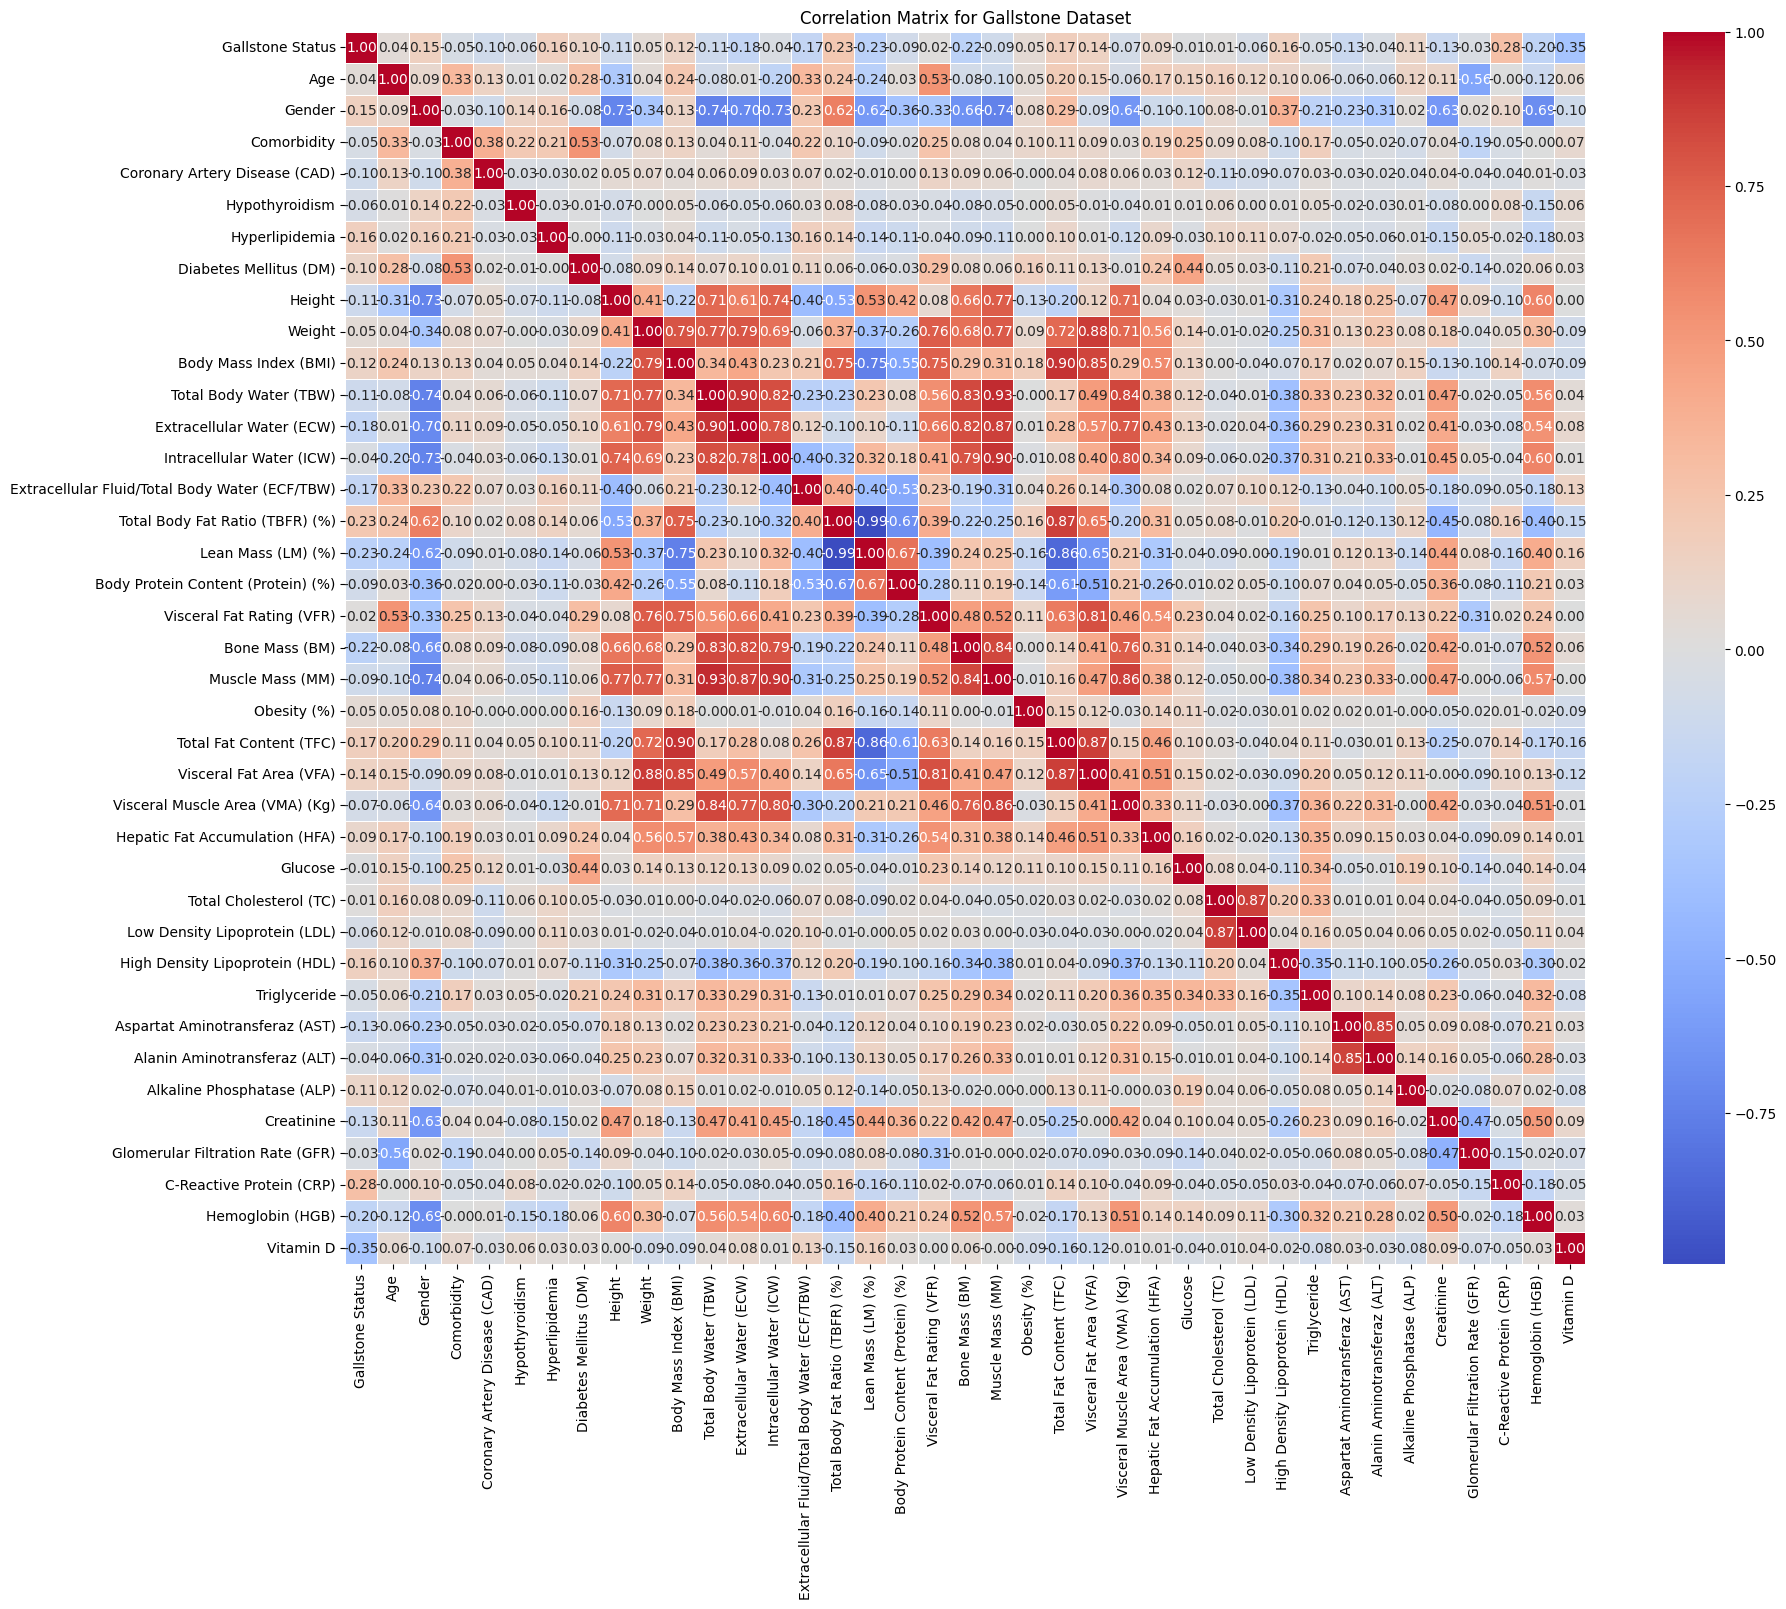

In [98]:
correlation_matrix = df.corr()

# Plot the full correlation matrix, including all features and the target variable
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Gallstone Dataset')
plt.show()

### Data Separation 
Separating the data according to data type to prepare for preprocessing and respective handling measures. Separation permits for more tailored pre-procesisng. 

Remark: 'lab_features' is a list of features pertaining to entries of lab tests. This separation was made based on advice from the instructor.

In [99]:
# -------------------------------
# Step 3: Separate features by type
# Lab test features (blood work and medical tests)
lab_features = ['Glucose', 'Total Cholesterol (TC)', 'Low Density Lipoprotein (LDL)', 'High Density Lipoprotein (HDL)', 
               'Triglyceride', 'Aspartat Aminotransferaz (AST)', 'Alanin Aminotransferaz (ALT)', 
               'Alkaline Phosphatase (ALP)', 'Creatinine', 'Glomerular Filtration Rate (GFR)', 
               'C-Reactive Protein (CRP)', 'Hemoglobin (HGB)', 'Vitamin D']

# Categorical features (binary/discrete variables)
categorical_features = ['Gender', 'Comorbidity', 'Coronary Artery Disease (CAD)', 'Hypothyroidism', 
                       'Hyperlipidemia', 'Diabetes Mellitus (DM)', 'Hepatic Fat Accumulation (HFA)']

# Numerical features (all remaining features that are not categorical or target)
numerical_features = [col for col in df.columns if col not in categorical_features + lab_features + [target_col]]


### Pre-processing Pipeline 


In [100]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### Train-Test Split 
The group decided on an 70-30 split (70% training, 30% testing as sourced from a general rule) to ensure a balance between training and testing data. 

Remark: random_state has been set to 42 to ensure reproducibility of results. 

In [101]:
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

### Pre-Processing Application 


In [102]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

## Model Configuration and Evaluation
The study will use the following means of feature selection:
- Correlation Heatmap 
- ANOVA F-Score

The models used in this study are:
- Random Forest
- Support Vector Machine
- Gradient Boosting
- Logistic Regression
- AdaBoost
- Decision Tree
- Bagging Classifier

The models will be evaluated using the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score
- AUC


### Model Dictionary & CV Setup

In [ ]:
# Define Models to be used
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=15000, random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Bagging Classifier': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42),
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


### Baseline Configuration

In [ ]:
X_train_baseline = X_train
X_test_baseline = X_test

# Train and evaluation loop 
results_baseline = {}
print(f"\n~~ BASELINE FEATURE SELECTION ~~\n")
for model_name, model in models.items():
    print(f"\nCross-validating {model_name}...")
    cross_val_evaluate(model, X_train_baseline, y_train, cv)

    # Fit model and evaluate on the test set
    model.fit(X_train_baseline, y_train)
    y_pred = model.predict(X_test_baseline)

    # if hasattr(model, "n_iter_"):
    #     print(f"Number of iterations taken (n_iter_): {model.n_iter_}")

    # Predicted Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_baseline)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_baseline)
        y_proba = (y_proba - y_proba.min())/(y_proba.max()-y_proba.min())
    else:
        y_proba = None
    
    print(f"\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n") # Divider

    # Evaluate model on the test set
    print(f"Test set evaluation for {model_name}:")
    evaluate_model(y_test, y_pred, y_proba)

    # Confusion Matrix Table
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Actual Negative', 'Actual Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])
    print(f"Confusion Matrix for {model_name}:")
    display(cm_df)



~~ BASELINE FEATURE SELECTION ~~


Cross-validating Random Forest...
Accuracy: 0.7310 (+/- 0.0593)
Precision: 0.7484 (+/- 0.1113)
Recall: 0.7273 (+/- 0.0575)
F1 Score: 0.7296 (+/- 0.0386)
ROC AUC: 0.8017 (+/- 0.0445)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Random Forest:
Accuracy: 0.8229
Precision: 0.7925
Recall: 0.8750
F1 Score: 0.8317
ROC AUC: 0.8828
Confusion Matrix for Random Forest:


Predicted Negative  Predicted Positive
Actual Negative                  37                  11
Actual Positive                   6                  42


Cross-validating SVM...
Accuracy: 0.4707 (+/- 0.0739)
Precision: 0.5351 (+/- 0.2571)
Recall: 0.3727 (+/- 0.2529)
F1 Score: 0.3562 (+/- 0.2045)
ROC AUC: 0.4918 (+/- 0.1377)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for SVM:
Accuracy: 0.6667
Precision: 0.7105
Recall: 0.5625
F1 Score: 0.6279
ROC AUC: 0.2999
Confusion Matrix for SVM:


Predicted Negative  Predicted Positive
Actual Negative                  37                  11
Actual Positive                  21                  27


Cross-validating Gradient Boosting...
Accuracy: 0.7083 (+/- 0.0337)
Precision: 0.7532 (+/- 0.0743)
Recall: 0.6273 (+/- 0.0668)
F1 Score: 0.6791 (+/- 0.0324)
ROC AUC: 0.7891 (+/- 0.0147)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Gradient Boosting:
Accuracy: 0.8021
Precision: 0.7959
Recall: 0.8125
F1 Score: 0.8041
ROC AUC: 0.8676
Confusion Matrix for Gradient Boosting:


Predicted Negative  Predicted Positive
Actual Negative                  38                  10
Actual Positive                   9                  39


Cross-validating Logistic Regression...
Accuracy: 0.7218 (+/- 0.0902)
Precision: 0.7575 (+/- 0.1353)
Recall: 0.6636 (+/- 0.1060)
F1 Score: 0.7021 (+/- 0.0973)
ROC AUC: 0.7809 (+/- 0.1112)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Logistic Regression:
Accuracy: 0.7812
Precision: 0.8140
Recall: 0.7292
F1 Score: 0.7692
ROC AUC: 0.8841
Confusion Matrix for Logistic Regression:


Predicted Negative  Predicted Positive
Actual Negative                  40                   8
Actual Positive                  13                  35


Cross-validating AdaBoost...
Accuracy: 0.7087 (+/- 0.0300)
Precision: 0.7453 (+/- 0.0579)
Recall: 0.6364 (+/- 0.0813)
F1 Score: 0.6813 (+/- 0.0396)
ROC AUC: 0.7599 (+/- 0.0483)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for AdaBoost:
Accuracy: 0.7396
Precision: 0.7347
Recall: 0.7500
F1 Score: 0.7423
ROC AUC: 0.8576
Confusion Matrix for AdaBoost:


Predicted Negative  Predicted Positive
Actual Negative                  35                  13
Actual Positive                  12                  36


Cross-validating Decision Tree...
Accuracy: 0.6592 (+/- 0.0536)
Precision: 0.6429 (+/- 0.0585)
Recall: 0.7091 (+/- 0.0936)
F1 Score: 0.6709 (+/- 0.0549)
ROC AUC: 0.6605 (+/- 0.0540)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Decision Tree:
Accuracy: 0.7188
Precision: 0.6981
Recall: 0.7708
F1 Score: 0.7327
ROC AUC: 0.7188
Confusion Matrix for Decision Tree:


Predicted Negative  Predicted Positive
Actual Negative                  32                  16
Actual Positive                  11                  37


Cross-validating Bagging Classifier...
Accuracy: 0.6681 (+/- 0.0462)
Precision: 0.7005 (+/- 0.0532)
Recall: 0.5818 (+/- 0.1233)
F1 Score: 0.6274 (+/- 0.0760)
ROC AUC: 0.7491 (+/- 0.0402)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Bagging Classifier:
Accuracy: 0.7917
Precision: 0.8182
Recall: 0.7500
F1 Score: 0.7826
ROC AUC: 0.7936
Confusion Matrix for Bagging Classifier:


Predicted Negative  Predicted Positive
Actual Negative                  40                   8
Actual Positive                  12                  36

### Correlation Heatmap
Feature seleciton based on the correlation heatmap of the Gallstone dataset. 

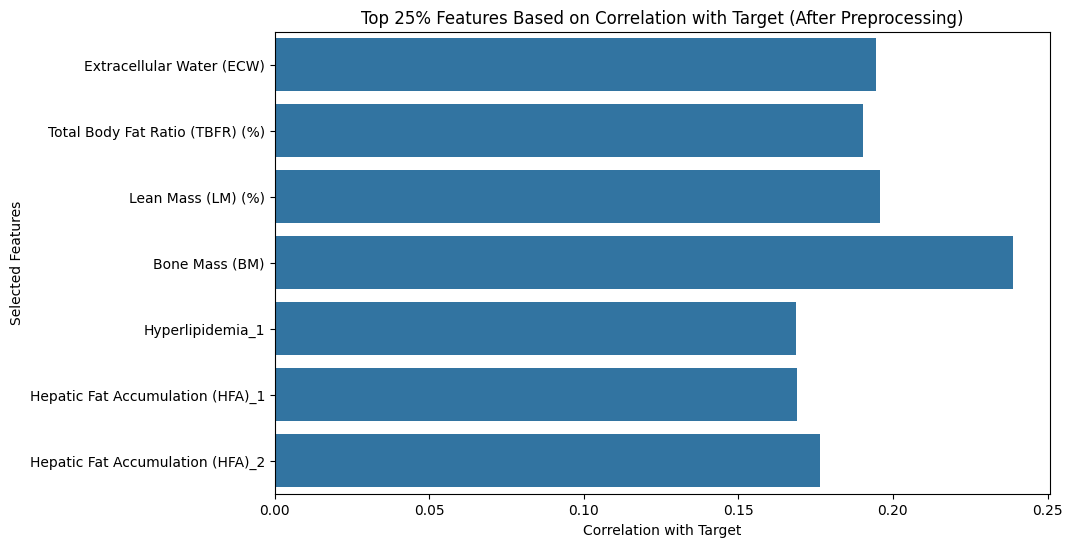


~~ CORRELATION HEATMAP FEATURE SELECTION ~~


Cross-validating Random Forest...
Accuracy: 0.5877 (+/- 0.0808)
Precision: 0.5964 (+/- 0.1016)
Recall: 0.5727 (+/- 0.0617)
F1 Score: 0.5801 (+/- 0.0649)
ROC AUC: 0.6281 (+/- 0.1024)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Random Forest:
Accuracy: 0.6458
Precision: 0.6750
Recall: 0.5625
F1 Score: 0.6136
ROC AUC: 0.7209
Confusion Matrix for Random Forest:


Predicted Negative  Predicted Positive
Actual Negative                  35                  13
Actual Positive                  21                  27


Cross-validating SVM...
Accuracy: 0.6501 (+/- 0.0469)
Precision: 0.6987 (+/- 0.0828)
Recall: 0.5455 (+/- 0.0953)
F1 Score: 0.6034 (+/- 0.0526)
ROC AUC: 0.6663 (+/- 0.0804)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for SVM:
Accuracy: 0.6875
Precision: 0.7812
Recall: 0.5208
F1 Score: 0.6250
ROC AUC: 0.7843
Confusion Matrix for SVM:


Predicted Negative  Predicted Positive
Actual Negative                  41                   7
Actual Positive                  23                  25


Cross-validating Gradient Boosting...
Accuracy: 0.5965 (+/- 0.0855)
Precision: 0.6098 (+/- 0.1111)
Recall: 0.5727 (+/- 0.0364)
F1 Score: 0.5872 (+/- 0.0643)
ROC AUC: 0.6766 (+/- 0.1059)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Gradient Boosting:
Accuracy: 0.6458
Precision: 0.6458
Recall: 0.6458
F1 Score: 0.6458
ROC AUC: 0.7342
Confusion Matrix for Gradient Boosting:


Predicted Negative  Predicted Positive
Actual Negative                  31                  17
Actual Positive                  17                  31


Cross-validating Logistic Regression...
Accuracy: 0.6634 (+/- 0.0948)
Precision: 0.6628 (+/- 0.0981)
Recall: 0.6455 (+/- 0.1091)
F1 Score: 0.6530 (+/- 0.1008)
ROC AUC: 0.6908 (+/- 0.0783)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Logistic Regression:
Accuracy: 0.6771
Precision: 0.6977
Recall: 0.6250
F1 Score: 0.6593
ROC AUC: 0.7643
Confusion Matrix for Logistic Regression:


Predicted Negative  Predicted Positive
Actual Negative                  35                  13
Actual Positive                  18                  30


Cross-validating AdaBoost...
Accuracy: 0.6411 (+/- 0.0738)
Precision: 0.6556 (+/- 0.1136)
Recall: 0.6182 (+/- 0.0464)
F1 Score: 0.6323 (+/- 0.0614)
ROC AUC: 0.6574 (+/- 0.1027)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for AdaBoost:
Accuracy: 0.6771
Precision: 0.6889
Recall: 0.6458
F1 Score: 0.6667
ROC AUC: 0.7281
Confusion Matrix for AdaBoost:


Predicted Negative  Predicted Positive
Actual Negative                  34                  14
Actual Positive                  17                  31


Cross-validating Decision Tree...
Accuracy: 0.5781 (+/- 0.0810)
Precision: 0.5825 (+/- 0.1010)
Recall: 0.5636 (+/- 0.0979)
F1 Score: 0.5680 (+/- 0.0819)
ROC AUC: 0.5785 (+/- 0.0799)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Decision Tree:
Accuracy: 0.6458
Precision: 0.6458
Recall: 0.6458
F1 Score: 0.6458
ROC AUC: 0.6458
Confusion Matrix for Decision Tree:


Predicted Negative  Predicted Positive
Actual Negative                  31                  17
Actual Positive                  17                  31


Cross-validating Bagging Classifier...
Accuracy: 0.6056 (+/- 0.0821)
Precision: 0.6360 (+/- 0.1250)
Recall: 0.5455 (+/- 0.0953)
F1 Score: 0.5769 (+/- 0.0718)
ROC AUC: 0.6403 (+/- 0.0897)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Bagging Classifier:
Accuracy: 0.7188
Precision: 0.7838
Recall: 0.6042
F1 Score: 0.6824
ROC AUC: 0.7335
Confusion Matrix for Bagging Classifier:


Predicted Negative  Predicted Positive
Actual Negative                  40                   8
Actual Positive                  19                  29

In [ ]:
X_train_preprocessed_df[target_feature] = y_train  # Add target for correlation calculation

corr_matrix = X_train_preprocessed_df.corr()
target_corr = corr_matrix[target_feature].abs()

percentile_threshold = np.percentile(target_corr, 75)
selected_features_corr = target_corr[target_corr > percentile_threshold].index

selected_features_corr = selected_features_corr.drop(target_feature)
plt.figure(figsize=(10,6))
sns.barplot(x=target_corr[selected_features_corr].values, y=selected_features_corr, orient='h')
plt.title('Top 25% Features Based on Correlation with Target (After Preprocessing)')
plt.xlabel('Correlation with Target')
plt.ylabel('Selected Features')
plt.show()

X_train_corr = X_train_preprocessed_df[selected_features_corr]
X_test_corr = X_test_preprocessed_df[selected_features_corr]

print(f"\n~~ CORRELATION HEATMAP FEATURE SELECTION ~~\n")
# Train and evaluate each model with selected features
results_corr = {}
for model_name, model in models.items():
    print(f"\nCross-validating {model_name}...")
    cross_val_evaluate(model, X_train_corr, y_train, cv)

    # Fit model and evaluate on the test set
    model.fit(X_train_corr, y_train)
    y_pred = model.predict(X_test_corr)

    # Predicted Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_corr)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_corr)
        y_proba = (y_proba - y_proba.min())/(y_proba.max()-y_proba.min())
    else:
        y_proba = None
    
    print(f"\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n") # Divider
    
    # Evaluate model on the test set
    print(f"Test set evaluation for {model_name}:")
    evaluate_model(y_test, y_pred, y_proba)

    # Confusion Matrix Table
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Actual Negative', 'Actual Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])
    print(f"Confusion Matrix for {model_name}:")
    display(cm_df)



### ANOVA F-Score Threshold

The ANOVA F-Score threshold was chosen based on the 75th percentile of the F-scores. This threshold was selected to ensure that only the most significant features were selected for the model.

Chosen F-score threshold (75th percentile): 4.604


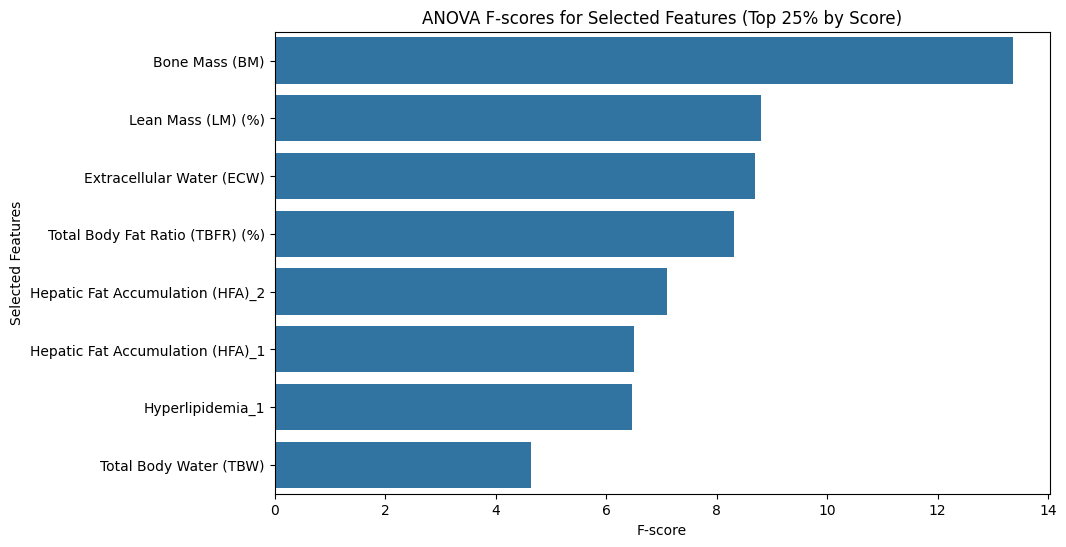


~~ ANOVA F-SCORE FEATURE SELECTION ~~


Cross-validating Random Forest...
Accuracy: 0.5964 (+/- 0.0529)
Precision: 0.5980 (+/- 0.0659)
Recall: 0.6000 (+/- 0.0782)
F1 Score: 0.5939 (+/- 0.0453)
ROC AUC: 0.6673 (+/- 0.0897)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Random Forest:
Accuracy: 0.7188
Precision: 0.7333
Recall: 0.6875
F1 Score: 0.7097
ROC AUC: 0.7626
Confusion Matrix for Random Forest:


Predicted Negative  Predicted Positive
Actual Negative                  36                  12
Actual Positive                  15                  33


Cross-validating SVM...
Accuracy: 0.6454 (+/- 0.0582)
Precision: 0.6909 (+/- 0.0916)
Recall: 0.5364 (+/- 0.1052)
F1 Score: 0.5955 (+/- 0.0709)
ROC AUC: 0.6943 (+/- 0.0755)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for SVM:
Accuracy: 0.7292
Precision: 0.8667
Recall: 0.5417
F1 Score: 0.6667
ROC AUC: 0.8056
Confusion Matrix for SVM:


Predicted Negative  Predicted Positive
Actual Negative                  44                   4
Actual Positive                  22                  26


Cross-validating Gradient Boosting...
Accuracy: 0.6685 (+/- 0.0775)
Precision: 0.6972 (+/- 0.1124)
Recall: 0.6364 (+/- 0.0643)
F1 Score: 0.6571 (+/- 0.0536)
ROC AUC: 0.7056 (+/- 0.0767)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Gradient Boosting:
Accuracy: 0.6875
Precision: 0.7045
Recall: 0.6458
F1 Score: 0.6739
ROC AUC: 0.7446
Confusion Matrix for Gradient Boosting:


Predicted Negative  Predicted Positive
Actual Negative                  35                  13
Actual Positive                  17                  31


Cross-validating Logistic Regression...
Accuracy: 0.6951 (+/- 0.0615)
Precision: 0.7137 (+/- 0.0717)
Recall: 0.6455 (+/- 0.0833)
F1 Score: 0.6750 (+/- 0.0675)
ROC AUC: 0.7202 (+/- 0.0766)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Logistic Regression:
Accuracy: 0.7292
Precision: 0.7619
Recall: 0.6667
F1 Score: 0.7111
ROC AUC: 0.8116
Confusion Matrix for Logistic Regression:


Predicted Negative  Predicted Positive
Actual Negative                  38                  10
Actual Positive                  16                  32


Cross-validating AdaBoost...
Accuracy: 0.6187 (+/- 0.0895)
Precision: 0.6075 (+/- 0.0819)
Recall: 0.6273 (+/- 0.1199)
F1 Score: 0.6160 (+/- 0.0989)
ROC AUC: 0.6585 (+/- 0.0880)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for AdaBoost:
Accuracy: 0.6458
Precision: 0.6667
Recall: 0.5833
F1 Score: 0.6222
ROC AUC: 0.7237
Confusion Matrix for AdaBoost:


Predicted Negative  Predicted Positive
Actual Negative                  34                  14
Actual Positive                  20                  28


Cross-validating Decision Tree...
Accuracy: 0.6184 (+/- 0.0888)
Precision: 0.6235 (+/- 0.0874)
Recall: 0.5727 (+/- 0.1367)
F1 Score: 0.5919 (+/- 0.1053)
ROC AUC: 0.6186 (+/- 0.0886)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Decision Tree:
Accuracy: 0.6771
Precision: 0.6809
Recall: 0.6667
F1 Score: 0.6737
ROC AUC: 0.6771
Confusion Matrix for Decision Tree:


Predicted Negative  Predicted Positive
Actual Negative                  33                  15
Actual Positive                  16                  32


Cross-validating Bagging Classifier...
Accuracy: 0.6411 (+/- 0.0331)
Precision: 0.6589 (+/- 0.0511)
Recall: 0.5818 (+/- 0.0727)
F1 Score: 0.6137 (+/- 0.0397)
ROC AUC: 0.6939 (+/- 0.0660)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Bagging Classifier:
Accuracy: 0.7083
Precision: 0.7500
Recall: 0.6250
F1 Score: 0.6818
ROC AUC: 0.7615
Confusion Matrix for Bagging Classifier:


Predicted Negative  Predicted Positive
Actual Negative                  38                  10
Actual Positive                  18                  30

In [ ]:
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_preprocessed, y_train)

f_scores = selector.scores_
all_feature_names = np.array(all_feature_names)  

feature_scores_df = pd.DataFrame({'Feature': all_feature_names, 'F_Score': f_scores})

threshold = feature_scores_df['F_Score'].quantile(0.75)
print(f"Chosen F-score threshold (75th percentile): {threshold:.3f}")

selected_features_mask = f_scores >= threshold
selected_feature_names = all_feature_names[selected_features_mask]

X_train_fscore = X_train_preprocessed[:, selected_features_mask]
X_test_fscore = X_test_preprocessed[:, selected_features_mask]

selected_f_scores = f_scores[selected_features_mask]
feature_scores_df_selected = pd.DataFrame({
    'Feature': selected_feature_names,
    'F_Score': selected_f_scores
})

plt.figure(figsize=(10,6))
sns.barplot(x='F_Score', y='Feature',
            data=feature_scores_df_selected.sort_values(by='F_Score', ascending=False))
plt.title('ANOVA F-scores for Selected Features (Top 25% by Score)')
plt.xlabel('F-score')
plt.ylabel('Selected Features')
plt.show()

# Train and evalation loop
results_fscore = {}
print(f"\n~~ ANOVA F-SCORE FEATURE SELECTION ~~\n")
for model_name, model in models.items():
    print(f"\nCross-validating {model_name}...")
    cross_val_evaluate(model, X_train_fscore, y_train, cv)

    # Fit model and evaluate on the test set
    model.fit(X_train_fscore, y_train)
    y_pred = model.predict(X_test_fscore)

    # Predicted Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_fscore)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_fscore)
        y_proba = (y_proba - y_proba.min())/(y_proba.max()-y_proba.min())
    else:
        y_proba = None

    print(f"\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n") # Divider
    
    # Evaluate model on the test set
    print(f"Test set evaluation for {model_name}:")
    evaluate_model(y_test, y_pred, y_proba)

    # Confusion Matrix Table
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Actual Negative', 'Actual Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])
    print(f"Confusion Matrix for {model_name}:")
    display(cm_df)

### Mixed Feature Selection Approach


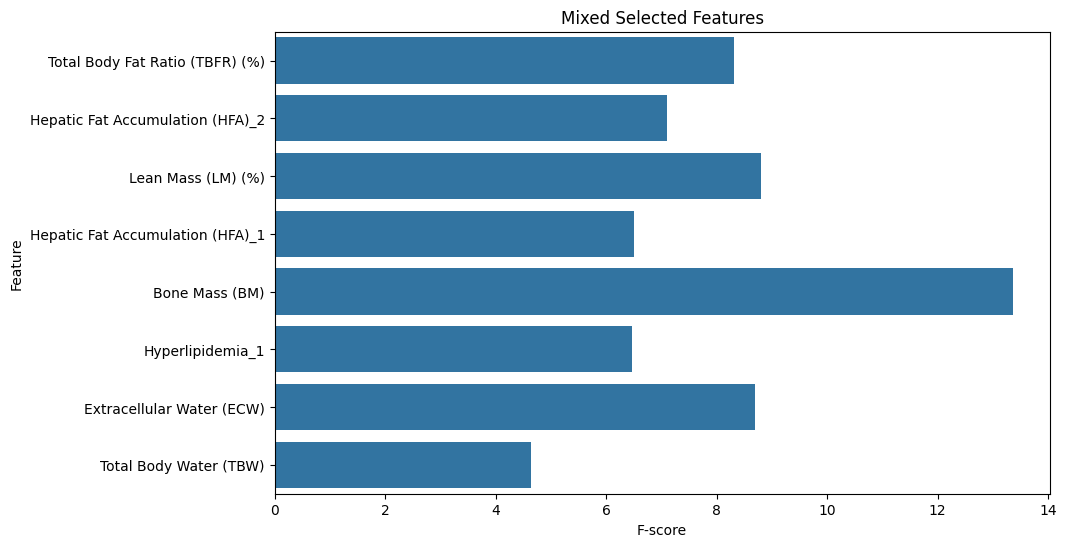


~~ MIXED FEATURE SELECTION ~~


Cross-validating Random Forest...
Accuracy: 0.6460 (+/- 0.0830)
Precision: 0.6739 (+/- 0.1288)
Recall: 0.6182 (+/- 0.0739)
F1 Score: 0.6354 (+/- 0.0625)
ROC AUC: 0.6708 (+/- 0.0952)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Random Forest:
Accuracy: 0.7188
Precision: 0.7333
Recall: 0.6875
F1 Score: 0.7097
ROC AUC: 0.7626
Confusion Matrix for Random Forest:


Predicted Negative  Predicted Positive
Actual Negative                  36                  12
Actual Positive                  15                  33


Cross-validating SVM...
Accuracy: 0.6454 (+/- 0.0582)
Precision: 0.6909 (+/- 0.0916)
Recall: 0.5364 (+/- 0.1052)
F1 Score: 0.5955 (+/- 0.0709)
ROC AUC: 0.6943 (+/- 0.0755)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for SVM:
Accuracy: 0.7292
Precision: 0.8667
Recall: 0.5417
F1 Score: 0.6667
ROC AUC: 0.8056
Confusion Matrix for SVM:


Predicted Negative  Predicted Positive
Actual Negative                  44                   4
Actual Positive                  22                  26


Cross-validating Gradient Boosting...
Accuracy: 0.6685 (+/- 0.0775)
Precision: 0.6972 (+/- 0.1124)
Recall: 0.6364 (+/- 0.0643)
F1 Score: 0.6571 (+/- 0.0536)
ROC AUC: 0.7052 (+/- 0.0762)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Gradient Boosting:
Accuracy: 0.6875
Precision: 0.7045
Recall: 0.6458
F1 Score: 0.6739
ROC AUC: 0.7446
Confusion Matrix for Gradient Boosting:


Predicted Negative  Predicted Positive
Actual Negative                  35                  13
Actual Positive                  17                  31


Cross-validating Logistic Regression...
Accuracy: 0.6951 (+/- 0.0615)
Precision: 0.7137 (+/- 0.0717)
Recall: 0.6455 (+/- 0.0833)
F1 Score: 0.6750 (+/- 0.0675)
ROC AUC: 0.7202 (+/- 0.0766)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Logistic Regression:
Accuracy: 0.7292
Precision: 0.7619
Recall: 0.6667
F1 Score: 0.7111
ROC AUC: 0.8116
Confusion Matrix for Logistic Regression:


Predicted Negative  Predicted Positive
Actual Negative                  38                  10
Actual Positive                  16                  32


Cross-validating AdaBoost...
Accuracy: 0.6187 (+/- 0.0895)
Precision: 0.6075 (+/- 0.0819)
Recall: 0.6273 (+/- 0.1199)
F1 Score: 0.6160 (+/- 0.0989)
ROC AUC: 0.6585 (+/- 0.0880)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for AdaBoost:
Accuracy: 0.6458
Precision: 0.6667
Recall: 0.5833
F1 Score: 0.6222
ROC AUC: 0.7237
Confusion Matrix for AdaBoost:


Predicted Negative  Predicted Positive
Actual Negative                  34                  14
Actual Positive                  20                  28


Cross-validating Decision Tree...
Accuracy: 0.6500 (+/- 0.0763)
Precision: 0.6652 (+/- 0.0913)
Recall: 0.6091 (+/- 0.1020)
F1 Score: 0.6305 (+/- 0.0798)
ROC AUC: 0.6502 (+/- 0.0758)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Decision Tree:
Accuracy: 0.6771
Precision: 0.6809
Recall: 0.6667
F1 Score: 0.6737
ROC AUC: 0.6771
Confusion Matrix for Decision Tree:


Predicted Negative  Predicted Positive
Actual Negative                  33                  15
Actual Positive                  16                  32


Cross-validating Bagging Classifier...
Accuracy: 0.6501 (+/- 0.0533)
Precision: 0.6911 (+/- 0.0979)
Recall: 0.5545 (+/- 0.0782)
F1 Score: 0.6091 (+/- 0.0555)
ROC AUC: 0.6843 (+/- 0.0672)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Test set evaluation for Bagging Classifier:
Accuracy: 0.7083
Precision: 0.7500
Recall: 0.6250
F1 Score: 0.6818
ROC AUC: 0.7615
Confusion Matrix for Bagging Classifier:


Predicted Negative  Predicted Positive
Actual Negative                  38                  10
Actual Positive                  18                  30

In [142]:
# 1. Fit preprocessor (if not yet)
preprocessor.fit(X_train)

# 2. Get column names post-preprocessing
numerical_names = numerical_features
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_names) + list(categorical_names)

# 3. Transform the train set
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 4. Convert to DataFrame
X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names, index=X_test.index)

# -----------------------------
# A. CORRELATION HEATMAP
# -----------------------------
# Add target temporarily
X_train_corr_df = X_train_df.copy()
X_train_corr_df['Gallstone Status'] = y_train

# Compute correlation with target
corr_matrix = X_train_corr_df.corr()
target_corr = corr_matrix['Gallstone Status'].drop('Gallstone Status').abs()

# Select top 25% correlation features
corr_threshold = np.percentile(target_corr, 75)
selected_corr_features = target_corr[target_corr > corr_threshold].index.tolist()

# -----------------------------
# B. ANOVA F-SCORE
# -----------------------------
# Get all F-scores
f_scores_all, _ = f_classif(X_train_df, y_train)
f_scores_series = pd.Series(f_scores_all, index=all_feature_names)

# Select top 25% f-score features
f_threshold = np.percentile(f_scores_series, 75)
selected_fscore_features = f_scores_series[f_scores_series > f_threshold].index.tolist()

# -----------------------------
# C. MIXED SELECTION: Intersection
# -----------------------------
selected_mixed_features = list(set(selected_corr_features) & set(selected_fscore_features))

# -----------------------------
# D. Visualize Mixed Selection
# -----------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x=f_scores_series[selected_mixed_features], y=selected_mixed_features)
plt.title('Mixed Selected Features')
plt.xlabel('F-score')
plt.ylabel('Feature')
plt.show()

# -----------------------------
# E. Final Train/Test Sets
# -----------------------------
X_train_mixed = X_train_df[selected_mixed_features]
X_test_mixed = X_test_df[selected_mixed_features]

results_mixed = {}

print(f"\n~~ MIXED FEATURE SELECTION ~~\n")
for model_name, model in models.items():
    print(f"\nCross-validating {model_name}...")
    cross_val_evaluate(model, X_train_mixed, y_train, cv)

    # Fit model and evaluate on the test set
    model.fit(X_train_fscore, y_train)
    y_pred = model.predict(X_test_fscore)

    # Predicted Probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_fscore)[:,1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_fscore)
        y_proba = (y_proba - y_proba.min())/(y_proba.max()-y_proba.min())
    else:
        y_proba = None

    print(f"\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n") # Divider
    
    # Evaluate model on the test set
    print(f"Test set evaluation for {model_name}:")
    evaluate_model(y_test, y_pred, y_proba)

    # Confusion Matrix Table
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Actual Negative', 'Actual Positive'], 
                         columns=['Predicted Negative', 'Predicted Positive'])
    print(f"Confusion Matrix for {model_name}:")
    display(cm_df)

## Application of XAI Techniques

### Application of SHAP onto best performing model
After conducting the extensive tests and configurations, the SHAP explainer will be augmented onto the Logistic Regression model of the Mixed configuration. 

In [143]:
# Define Models
lr_model = models['Logistic Regression']

# Feature names after preprocessing and selection (from your notebook)
feature_names = selected_feature_names

In [154]:
def plot_shap_global_kernel(model, X, feature_names, model_name):
    """
    Generate SHAP global interpretability plots (bar + beeswarm) for linear models like Logistic Regression
    using preprocessed input features with semantic names.
    
    Parameters:
    - model: trained logistic regression model
    - X: pandas DataFrame of selected preprocessed features (e.g., X_train_mixed)
    - feature_names: list of column names used in X
    - model_name: string label for the plot title
    """

    # Use shap.Explainer (automatically chooses LinearExplainer for sklearn.linear_model.LogisticRegression)
    explainer = shap.Explainer(model, X, feature_names=feature_names)
    shap_values = explainer(X)

    # Plot 1: Bar Plot of Mean Absolute SHAP Values (Global Importance)
    plt.figure(figsize=(10, 6))
    shap.plots.bar(shap_values, show=False)
    plt.title(f"SHAP Global Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()

    # Plot 2: Beeswarm Plot (distribution + impact)
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(shap_values, show=False)
    plt.title(f"SHAP Beeswarm Plot - {model_name}")
    plt.tight_layout()
    plt.show()

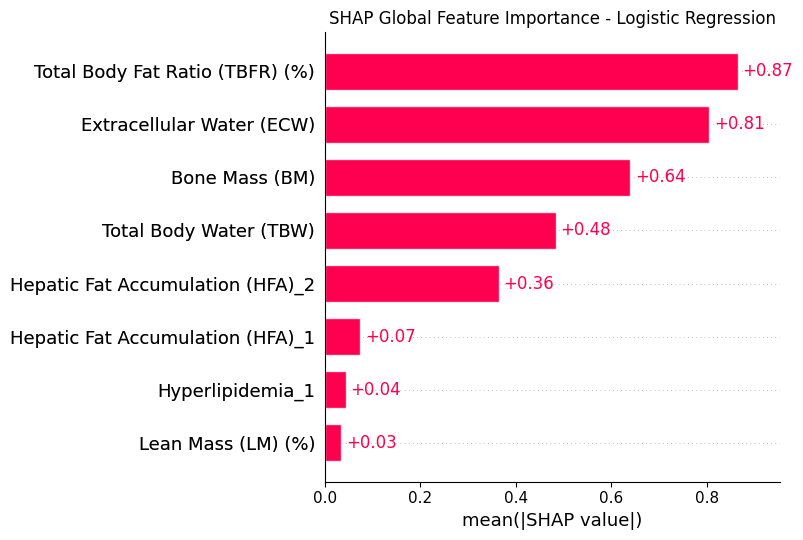

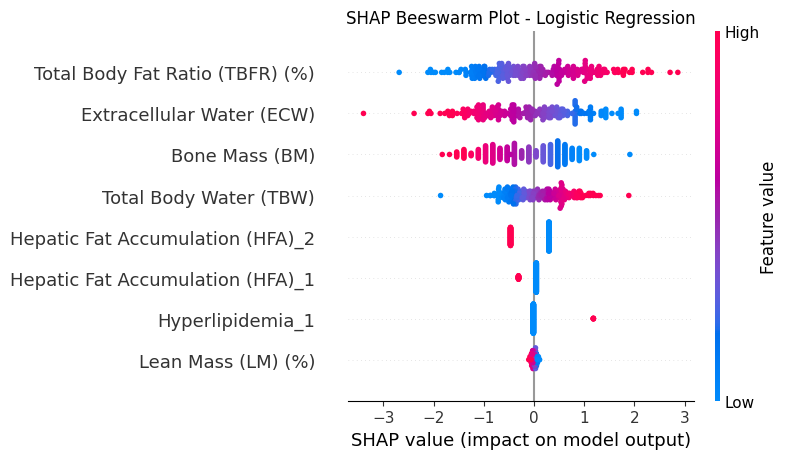

In [156]:
# Call with Mixed configuration model and data
plot_shap_global_kernel(lr_model, X_train_mixed, selected_mixed_features, "Logistic Regression")

### Application of LIME to a Positive and Negative Sample.
The Explainable AI LIME will be applied to a positive and negative sample to add further context to predictions made 

In [157]:
# Initializing LIME explainer using traning data and feature names
lime_explainer = LimeTabularExplainer(
    training_data=X_train_mixed.values,
    feature_names=selected_mixed_features,
    class_names=['No Gallstone', 'Gallstone'],
    mode='classification'
)

In [158]:
# First indices of positive and negative samples
pos_idx = np.where(y_test == 1)[0][0]  # first positive
neg_idx = np.where(y_test == 0)[0][0]  # first negative

In [159]:
lime_exp_pos = lime_explainer.explain_instance(
    data_row=X_test_mixed.iloc[pos_idx].values,
    # predict_fn=best_estimators['Gradient Boosting'].predict_proba,
    predict_fn=models['Logistic Regression'].predict_proba,
    num_features=8  # number of features to include in explanation
)

# Display explanation in notebook
lime_exp_pos.show_in_notebook(show_table=True)

In [160]:
lime_exp_neg = lime_explainer.explain_instance(
    data_row=X_test_mixed.iloc[neg_idx].values,
    predict_fn=models['Logistic Regression'].predict_proba,
    num_features=8
)

# Display explanation in notebook
lime_exp_neg.show_in_notebook(show_table=True)

In [161]:
html_pos = lime_exp_pos.as_html()
html_neg = lime_exp_neg.as_html()

with open("html_pos.html", "w", encoding="utf-8") as f:
    f.write(html_pos)

with open("html_neg.html", "w", encoding="utf-8") as f:
    f.write(html_neg)